# Spline approximations
In this notebook we fit and compare various spline approximation method implemented in `bletl.splines`.

In [1]:
import ipywidgets
from matplotlib import cm, pyplot
import numpy
import pandas
import pathlib

import bletl

DP_DATA = pathlib.Path("..", "data")
DP_RESULTS = pathlib.Path("..", "results")

## Load the dataset

In [2]:
bldata = bletl.parse(DP_DATA / "8X4PF4.csv")

## Prepare a detailed comparison of the `"us"` and `"ucss"` spline methods
Not all "smoothing splines" are created equal.
In the following comparison, we can see that the choice of the algorithm dramatically impacts the extrapolation behavior and smoothness of derivatives.

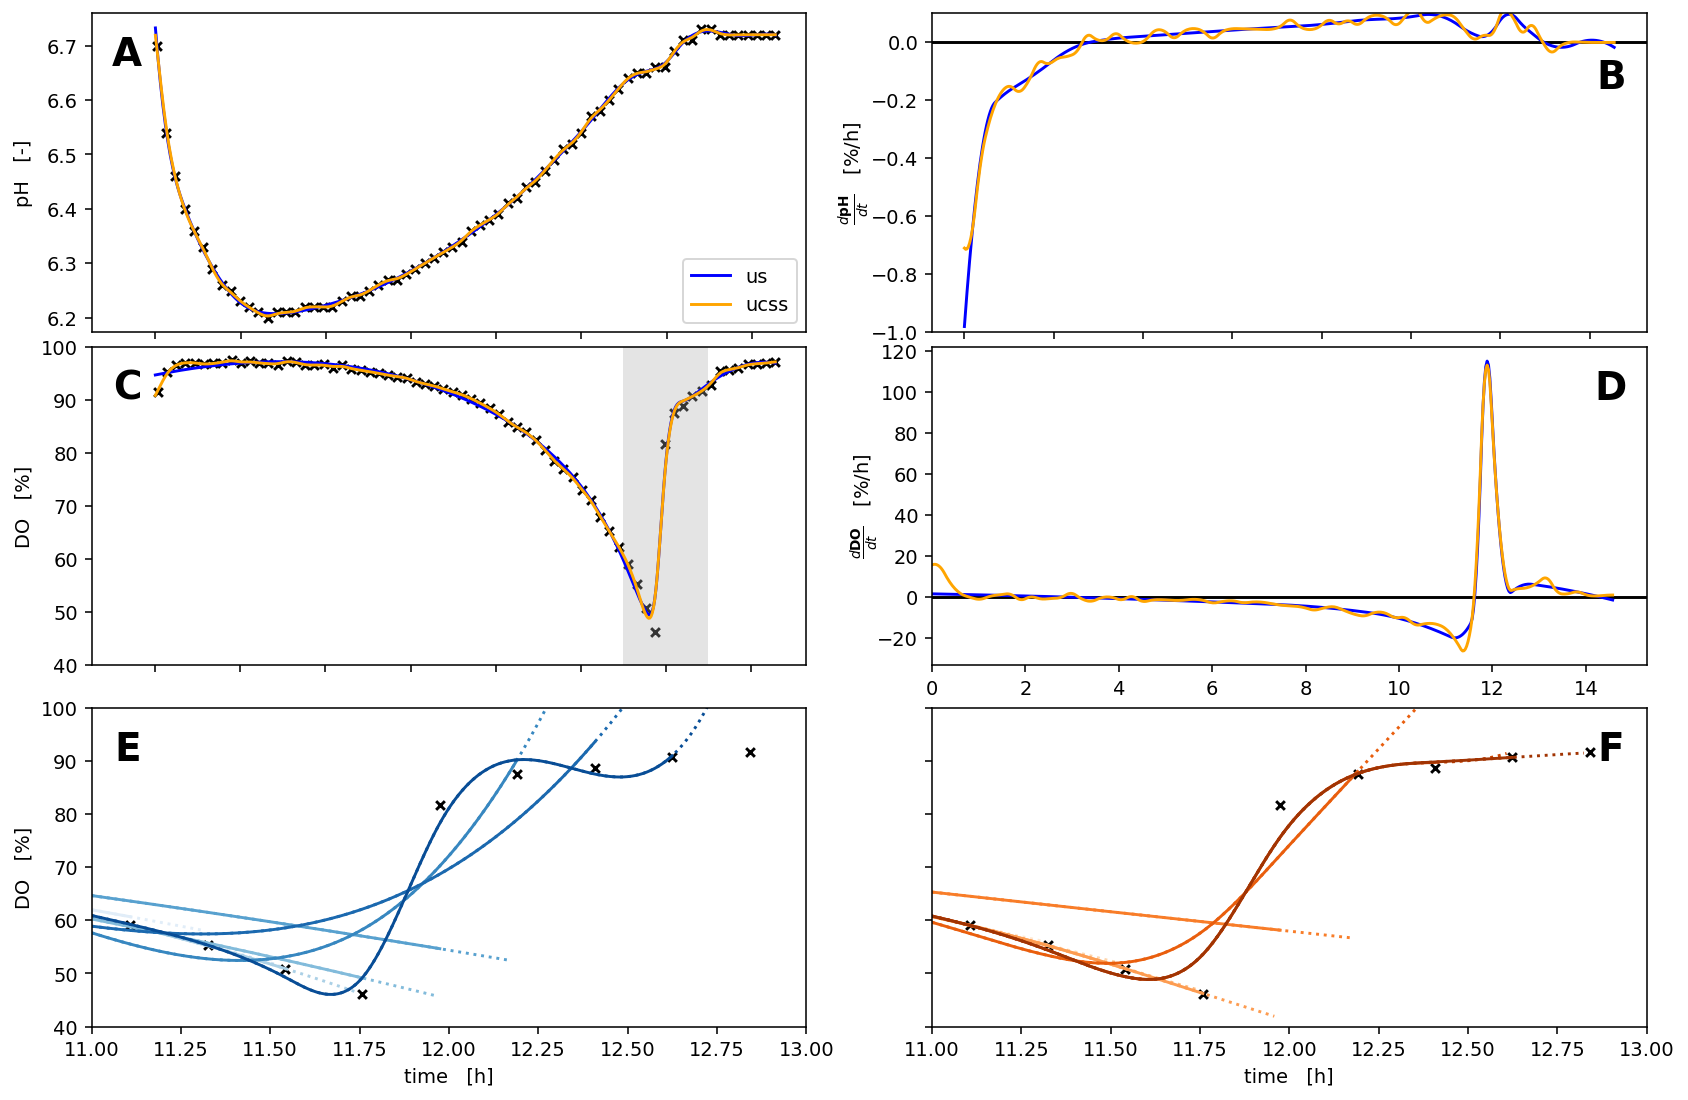

In [3]:
well = "A01"
C = 68

fig, axs = pyplot.subplots(
    dpi=140, figsize=(12,8),
    nrows=3, ncols=2,
)

# pH in the first row
left, right = axs[0, :]
t, ph = bldata.get_timeseries("pH", well, last_cycle=C)
t_dense = numpy.linspace(0, t[-1], 500)
left.scatter(t, ph, color="black", marker="x", s=20)
right.axhline(0, color="black")
for method, color in [("us", "blue"), ("ucss", "orange")]:
    spline = bletl.get_crossvalidated_spline(t, ph, method=method)
    left.plot(
        t_dense, spline(t_dense),
        label=method, color=color,
    )
    right.plot(
        t_dense, spline.derivative(1)(t_dense),
        color=color,
    )

left.legend()
left.set(
    ylabel="pH   [-]",
    xticklabels=[],
)
right.set(
    ylabel=r"$\frac{d\mathbf{pH}}{dt}$   [%/h]",
)

# DO to the right
left, right = axs[1, :]
t, do = bldata.get_timeseries("DO", well, last_cycle=C)
t_dense = numpy.linspace(0, t[-1], 500)
left.scatter(t, do, color="black", marker="x", s=20)
right.axhline(0, color="black")
for method, color in [("us", "blue"), ("ucss", "orange")]:
    spline = bletl.get_crossvalidated_spline(t, do, method=method)
    left.plot(
        t_dense, spline(t_dense),
        label=method, color=color,
    )
    right.plot(
        t_dense, spline.derivative(1)(t_dense),
        color=color,
    )
left.fill_between(
    x=[11, 13],
    y1=[40, 40],
    y2=[100, 100],
    facecolor="#AAAAAA50"
)
left.set(
    ylabel="DO   [%]",
    ylim=(40, 100),
    xticklabels=[],
)
right.set(
    ylabel=r"$\frac{d\mathbf{DO}}{dt}$   [%/h]",
    xlim=(0, None),
)


# Bottom: Zoomed-in comparison between methods
left, right = axs[-1,:]
X_LIM = (11, 13)
t, do = bldata.get_timeseries("DO", well, last_cycle=C)
left.scatter(t, do, color="black", marker="x", s=20)
right.scatter(t, do, color="black", marker="x", s=20)

cycles = tuple(range(52, 60))
for i, c in enumerate(cycles):
    t, do = bldata.get_timeseries("DO", well, last_cycle=c)
    t_dense = numpy.linspace(X_LIM[0], t[-1], 300)
    t_plus = numpy.linspace(X_LIM[0], t[-1] + 0.2, 300)
    
    for method, cmap, ax in [("us", cm.Blues, left), ("ucss", cm.Oranges, right)]:
        color = cmap(1 / (len(cycles) + 1) * (i + 1))
        spline = bletl.get_crossvalidated_spline(t, do, method=method)
        ax.plot(
            t_dense, spline(t_dense),
            label=method, color=color,# alpha=alpha,
        )
        ax.plot(
            t_plus, spline(t_plus),
            label=method, color=color,# alpha=alpha,
            linestyle=":",
        )
left.set(
    xlim=X_LIM,
    ylim=(40, 100),
    xlabel="time   [h]",
    ylabel="DO   [%]",
)
right.set(
    xlim=X_LIM,
    ylim=(40, 100),
    xlabel="time   [h]",
    yticklabels=[],
)

# General formatting
fig.align_ylabels()
fig.tight_layout(pad=0.5)
# move the top row down
for ax in axs[1, :]:
    bb = ax.get_position()
    ax.set_position([bb.x0, bb.y0 + 0.025, bb.width, bb.height])  
axs[0, 1].set_ylabel(axs[0, 1].get_ylabel(), labelpad=0)
axs[1, 1].set_ylabel(axs[1, 1].get_ylabel(), labelpad=-5)
# move the bottom row up
for ax in axs[-1, :]:
    bb = ax.get_position()
    ax.set_position([bb.x0, bb.y0 + 0.025, bb.width, bb.height])  

common = dict(ha="center", va="center", size=20, weight="bold")
axs[0, 0].set_xlim(-1.5, None)
axs[0, 0].text(0.05, 0.87, "A", **common, transform=axs[0, 0].transAxes)
axs[0, 1].set_ylim(-1, 0.1)
axs[0, 1].text(0.95, 0.8, "B", **common, transform=axs[0, 1].transAxes)
axs[1, 0].set_xlim(-1.5, None)
axs[1, 0].text(0.05, 0.87, "C", **common, transform=axs[1, 0].transAxes)
axs[1, 1].text(0.95, 0.87, "D", **common, transform=axs[1, 1].transAxes)
axs[2, 0].text(0.05, 0.87, "E", **common, transform=axs[2, 0].transAxes)
axs[2, 1].text(0.95, 0.87, "F", **common, transform=axs[2, 1].transAxes)
    
fig.savefig(DP_RESULTS / "fig_splines.pdf")
fig.savefig(DP_RESULTS / "fig_splines.png")
pyplot.show()

In [4]:
%load_ext watermark
%watermark

Last updated: 2021-08-06T14:52:16.177784+02:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.25.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 6
Architecture: 64bit

